Accuracy : 42.68%
NMI      : 0.4088
ARI      : 0.1601


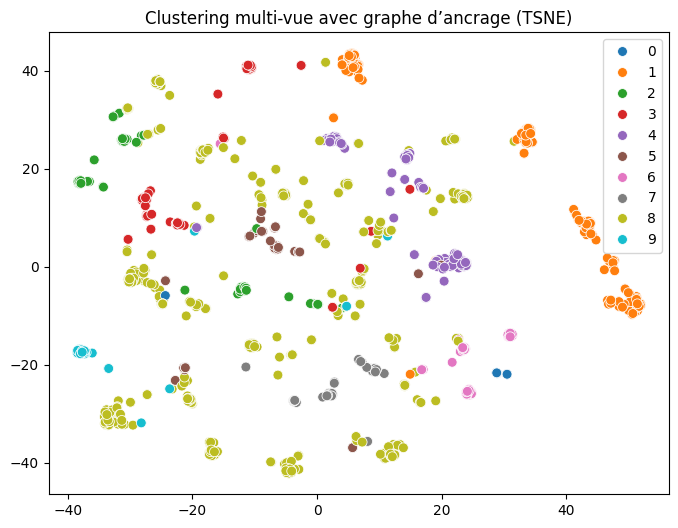

In [4]:
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores*")
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances

# Chargement du dataset Digits
digits = load_digits()
X = digits.data
y = digits.target

# Création de 2 vues simulées
X_view1 = PCA(n_components=30).fit_transform(X)
X_view2 = X + np.random.normal(0, 0.2, X.shape)
X_view2 = PCA(n_components=30).fit_transform(X_view2)

# Normalisation
scaler = StandardScaler()
X_view1 = scaler.fit_transform(X_view1)
X_view2 = scaler.fit_transform(X_view2)

# Nombre d'ancres
n_anchors = 50

# KMeans pour obtenir les centres (ancres)
kmeans1 = KMeans(n_clusters=n_anchors, random_state=42).fit(X_view1)
anchors1 = kmeans1.cluster_centers_

kmeans2 = KMeans(n_clusters=n_anchors, random_state=42).fit(X_view2)
anchors2 = kmeans2.cluster_centers_

# Construction du graphe d’ancrage
def build_anchor_graph(X, anchors, k=5):
    dist = euclidean_distances(X, anchors)
    idx = np.argsort(dist, axis=1)[:, :k]
    Z = np.zeros((X.shape[0], anchors.shape[0]))
    for i in range(X.shape[0]):
        for j in idx[i]:
            Z[i, j] = np.exp(-dist[i, j] ** 2)
        Z[i] /= Z[i].sum()
    return Z

Z1 = build_anchor_graph(X_view1, anchors1)
Z2 = build_anchor_graph(X_view2, anchors2)

# Fusion simple (moyenne)
Z_fused = (Z1 + Z2) / 2

# Clustering
kmeans = KMeans(n_clusters=10, random_state=42).fit(Z_fused)
y_pred = kmeans.labels_

# Fonction accuracy non supervisée
def clustering_accuracy(y_true, y_pred):
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int32)
    for i in range(len(y_true)):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(*ind)]) / len(y_true)

# Évaluation
acc = clustering_accuracy(y, y_pred)
nmi = normalized_mutual_info_score(y, y_pred)
ari = adjusted_rand_score(y, y_pred)

print(f"Accuracy : {acc * 100:.2f}%")
print(f"NMI      : {nmi:.4f}")
print(f"ARI      : {ari:.4f}")

# Visualisation TSNE
Z_tsne = TSNE(n_components=2, random_state=42).fit_transform(Z_fused)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z_tsne[:, 0], y=Z_tsne[:, 1], hue=y_pred, palette='tab10', s=50)
plt.title("Clustering multi-vue avec graphe d’ancrage (TSNE)")
plt.show()